In [4]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 95%; }
</style>
"""))

In [5]:
from urllib.parse import quote_plus
import sqlalchemy as sa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc # For the legend
from matplotlib.cm import ScalarMappable
import seaborn as sns
import re
import numbers
%matplotlib inline
# sns.set_style('whitegrid')
# sns.set_context('talk')
import boto3
import pickle
import time
import math

import datetime
from datetime import timedelta 
import matplotlib.dates as mdates
from collections import defaultdict

### Read in Data

In [6]:
zone_map = {'4C': 'Seattle', '3A': 'Atlanta', '5B': 'Denver', '2B': 'Tucson', '4A': 'New York',
            '3C': 'San Diego', '2A': 'Tampa', '4B': 'Albuquerque', '5A': 'Buffalo', '3B': 'Midland',
            '6A': 'Rochester', '7': 'International Falls', '6B': 'Great Falls', '5C': 'Port Angeles'}

In [7]:
saving_shapes_dir = './output_csvs/v2.5.0/all_bugfix/savings_shape'
keys = ['Climate Zone', 'Net Load Version', 'End Use', 'Building Type']

# saving_shapes_dir = './output_csvs/Run_2_11.24.20/savings_shape'
# keys = ['Climate Zone', 'Net Load Version', 'End Use']

upgrades = defaultdict(dict)
for filename in os.listdir(saving_shapes_dir):
    f = os.path.join(saving_shapes_dir, filename)
    package = filename.split('_')[0][1:]
    df = pd.read_csv(f)
    df = df.set_index(keys).sort_index()
    for idx in df.index.unique():
        if len(idx)==4: cz, load_version, enduse, btype = idx
        if len(idx)==3: cz, load_version, enduse = idx
        
        location = f"{zone_map[cz]}_{load_version}" 
        key = (package, location, enduse, btype)
        upgrades[key] = df.loc[idx].reset_index(drop=True)

In [86]:
packages = set([key[0] for key in upgrades.keys()])
locations = set([key[1] for key in upgrades.keys()])
enduses = set([key[2] for key in upgrades.keys()])
btypes = set([key[3] for key in upgrades.keys()])

In [8]:
zone_map = {'4C': 'Seattle', '3A': 'Atlanta', '5B': 'Denver', '2B': 'Tucson', '4A': 'New York',
            '3C': 'San Diego', '2A': 'Tampa', '4B': 'Albuquerque', '5A': 'Buffalo', '3B': 'Midland',
            '6A': 'Rochester', '7': 'International Falls', '6B': 'Great Falls', '5C': 'Port Angeles'}

df_pk_hrs = pd.read_csv('../Resstock_inputs/peak_take_periods_2022.csv', skipfooter=3).dropna(axis=1)
df_pk_hrs['city'] = df_pk_hrs['ASH Climate'].map(zone_map)
cities = df_pk_hrs['city']
netloads = df_pk_hrs['Net Load Version']
dup_cities = list(df_pk_hrs[df_pk_hrs['Net Load Version']==2]['city'])
df_pk_hrs['City Label'] = [city + '_' + str(netload) if city in dup_cities else city for city, netload in zip(cities, netloads)]
df_pk_hrs.head()

C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_5496\731835084.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_pk_hrs = pd.read_csv('../Resstock_inputs/peak_take_periods_2022.csv', skipfooter=3).dropna(axis=1)


,ASH Climate,Net Load Version,EMM Region #,EMM Region Name,Winter-PeakStartHr,Winter-PeakEndHr,Summer-PeakStartHr,Summer-PeakEndHr,Winter-TakeStartHr1,Winter-TakeEndHr1,Summer-TakeStartHr1,Summer-TakeEndHr1,city,City Label
0,2A,1,2,FRCC,17,20,17,20,11,15,9,12,Tampa,Tampa_1
1,2A,2,6,MISS,18,21,17,20,12,15,10,14,Tampa,Tampa_2
2,2B,1,20,SRSG,19,22,17,20,11,15,9,14,Tucson,Tucson
3,3A,1,15,SRSE,17,20,17,20,12,15,11,13,Atlanta,Atlanta_1
4,3A,2,1,TRE,20,23,18,21,12,16,11,13,Atlanta,Atlanta_2


## Figures

### All Upgrades

In [ ]:
city = 'Denver_1'
enduse = 'cooling'
# enduse = 'electricity_dishwasher_kwh'
btype = 'SF'
upgrades_ts_b = upgrades_ts[btype]

ups = sorted(upgrades_ts_b.upgrade.unique())
rows = 4
n_cols = len(ups)/rows
fig, axs = plt.subplots(rows, math.ceil(n_cols), figsize=(20,15), sharey=False)

for ct, up in enumerate(ups):
    row_idx = int(math.floor(ct/n_cols))
    col_idx = int(ct%n_cols)
    
    df_up = upgrades_ts_b[(upgrades_ts_b["upgrade"]==up) & (upgrades_ts_b.city==city)]
    df_base_b = baseline_ts_map[up][btype]
    df_base_b = df_base_b[df_base_b.city==city]

    period = 24*6
    if enduse == 'heating':
        start = 1
        col = 'electricity_heating_kwh'
    elif enduse == 'cooling':
        start = 4500
        col = 'electricity_cooling_kwh'
    else:
        start = 1
        col = enduse
        
    ax = axs[row_idx, col_idx]
    ax.plot(range(period), df_base_b.iloc[start:start+period][col], '--', label='Baseline')
    ax.plot(range(period), df_up.iloc[start:start+period][col], label='Upgrade')    
    ax.set_title(up_names[up].split('package ')[1], fontsize=9)
    
    if ct%rows == 0:
        ax.legend()
        ax.set_ylabel(f'{col}')

plt.tight_layout()

### Single Upgrade

In [9]:
upgrade_map = {'1a': 'package 1a ee cac',
               '1b': 'package 1b ee ashp',
               '1c': 'package 1c ee best smart thermostat',
               '1d': 'package 1d ee best envelope',
               '1e': 'package 1e ee best appliances',
               '1f': 'package 1f ee cac with smart thermostat and envelope',
               '1g': 'package 1g ee ashp with smart thermostat and best envelope',
               '1h': 'package 1h ee smart thermostat & envelope when not upgrading cac or ashp',
               '1j': 'package 1j ee best opaque envelope',
               '1k': 'package 1k ee best air sealing',
               '1m': 'package 1m ee best windows',
               '2': 'package 2 dr only',
               '3a': 'package 3a pre-heating/cooling, smart thermostat, and envelope for cac upgrades',
               '3b': 'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
               '3c': 'package 3c pre-heating/cooling, smart thermostat, and envelope for no hvac upgrades',
               '3d': 'package 3d appliance ee+dr'}

In [10]:
def plot_single_upgrade(upgrade, city, enduse, start, period=5*24, btypes=[], showfig=True, savefig=False):
    col = enduse
    start *= 24
    start -= 1
    if start <3000:
        pkprefix = 'Winter-'
    else:
        pkprefix = 'Summer-'
        
    zone = df_pk_hrs[df_pk_hrs['City Label']==city]['ASH Climate'].values[0]  
    peaks = df_pk_hrs[df_pk_hrs['City Label']==city]
    peak1, peak2 = peaks[f'{pkprefix}PeakStartHr'].values[0], peaks[f'{pkprefix}PeakEndHr'].values[0]
    take1, take2 = peaks[f'{pkprefix}TakeStartHr1'].values[0], peaks[f'{pkprefix}TakeEndHr1'].values[0]
    
    fig, axs = plt.subplots(len(btypes), 1, figsize=(15,3*len(btypes)), sharey=False, sharex=True)
    x = np.arange(period)
    for ct, btype in enumerate(btypes):
        if type(axs) == np.ndarray:
            ax = axs[ct]
        else:
            ax = axs
        upgrade_key = (upgrade, city, enduse, btype)
        upgrade_df = upgrades[upgrade_key]
        data_base = upgrade_df['Baseline Load']
        data_upgrade = upgrade_df['Measure Load']
                
        ax.plot(x, data_base.iloc[start:start+period], '--', label='Baseline')
        ax.plot(x, data_upgrade.iloc[start:start+period], label='Upgrade')
        
        for i, d in enumerate(range(int(period/24))):
            hrs = d*24
            if i == 0:
                labelpk = 'Peak'
                labeltk = 'Take'
            else:
                labelpk = None
                labeltk = None
                
            ax.axvspan(hrs+peak1-1, hrs+peak2, alpha=.2, color='red', label=labelpk) # -2 to adjust for 1) 0-index and 2) for hour-ending
            ax.axvspan(hrs+take1-1, hrs+take2, alpha=.1, color='blue', label=labeltk)
#         ax.set_title(f'{btype} {city} ({zone}): {upgrade_map[upgrade]} [{enduse}]')
        ax.set_title(f'{upgrade_map[upgrade].capitalize()}: {btype} {city} ({zone}) [{enduse}]')
        
        ax.set_ylabel(col)
        ax.legend()
            
    interval = 4      
    base_time = datetime.datetime(2018, 1, 1, 0) 
    xticklabels = [(base_time + datetime.timedelta(hours=x)).strftime('%m/%d %H:%M') for x in range(start+1, start+1+period, interval)]    
    xticks = np.arange(0, period, interval)
    ax.set_xticks(xticks, xticklabels, rotation=30, ha='right')
    xfmt = mdates.DateFormatter('%m-%d %H:%M')
    
    plt.xlabel('Time')
    plt.tight_layout()
    
    if savefig:
        package = f'P{upgrade}'
        month = xticklabels[0][:2]
        plt.savefig(f'../Resstock_results/v2.5.0_runs_bugfix/spot_check_figs/{package}_{city}_{enduse}_{month}.png',dpi=450)
        
    if not showfig:
        plt.close()

### Generate Figures

In [247]:
upgrade_map

{'1a': 'package 1a ee cac',
 '1b': 'package 1b ee ashp',
 '1c': 'package 1c ee best smart thermostat',
 '1d': 'package 1d ee best envelope',
 '1e': 'package 1e ee best appliances',
 '1f': 'package 1f ee cac with smart thermostat and envelope',
 '1g': 'package 1g ee ashp with smart thermostat and best envelope',
 '1h': 'package 1h ee smart thermostat & envelope when not upgrading cac or ashp',
 '1j': 'package 1j ee best opaque envelope',
 '1k': 'package 1k ee best air sealing',
 '1m': 'package 1m ee best windows',
 '2': 'package 2 dr only',
 '3a': 'package 3a pre-heating/cooling, smart thermostat, and envelope for cac upgrades',
 '3b': 'package 3b pre-heating/cooling, smart thermostat, and envelope for ashp upgrades',
 '3c': 'package 3c pre-heating/cooling, smart thermostat, and envelope for no hvac upgrades',
 '3d': 'package 3d appliance ee+dr'}

In [246]:
enduses

{'clothes washing',
 'cooling',
 'dishwasher',
 'drying',
 'heating',
 'lighting',
 'plug loads',
 'pool heaters and pumps',
 'refrigeration',
 'water heating'}

C:\Users\aspeake\AppData\Local\Temp\1\ipykernel_50120\3884692545.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(len(btypes), 1, figsize=(15,3*len(btypes)), sharey=False, sharex=True)


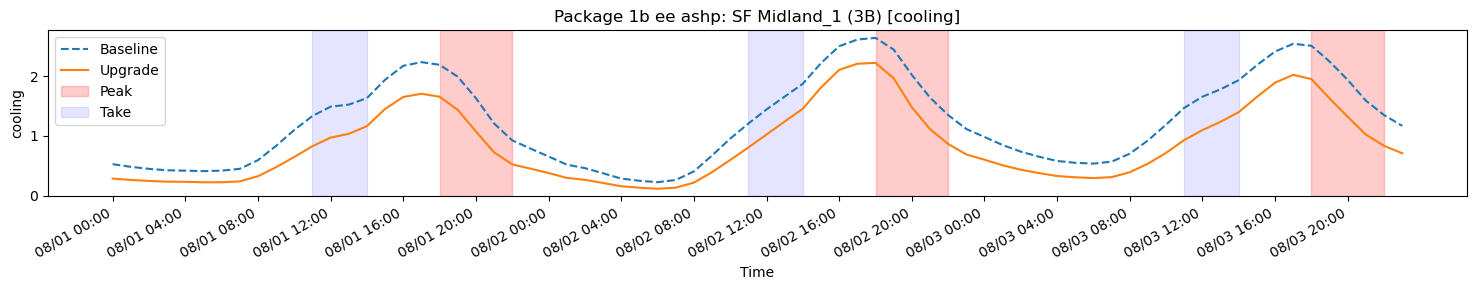

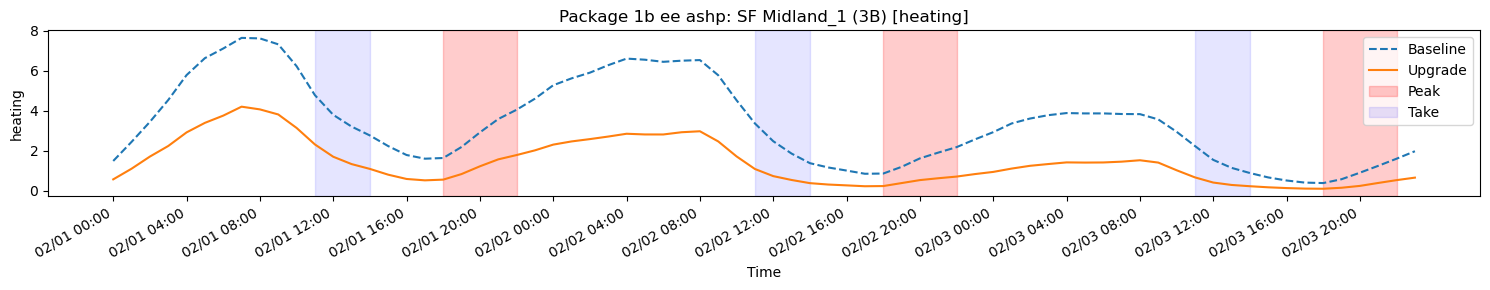

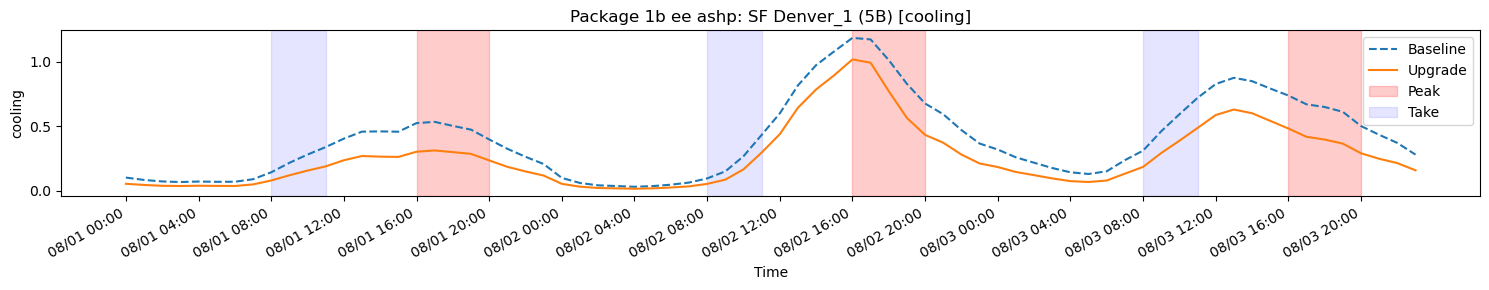

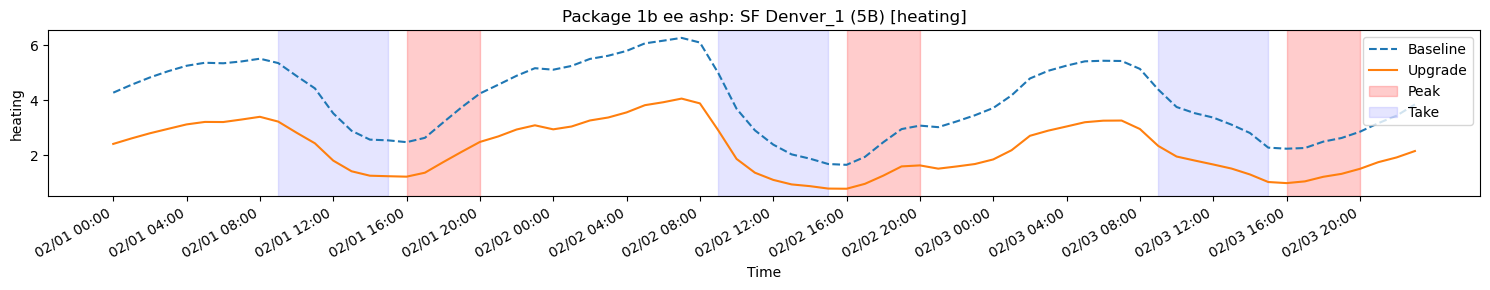

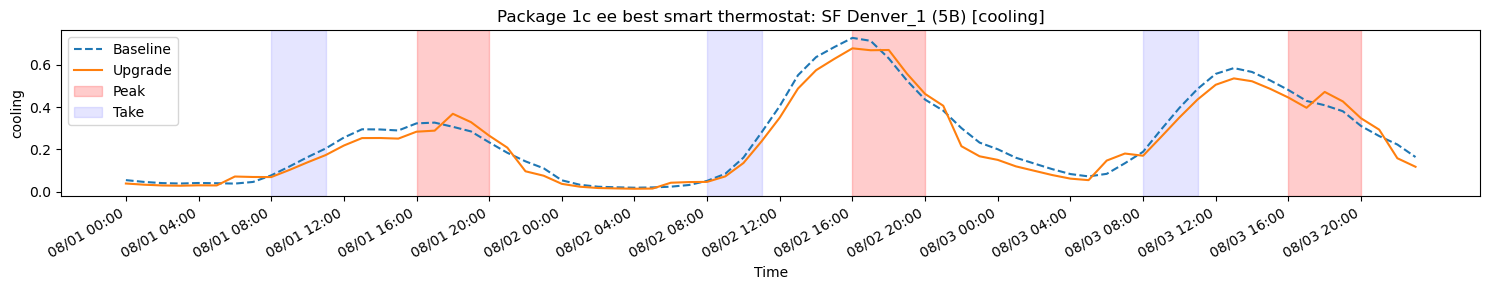

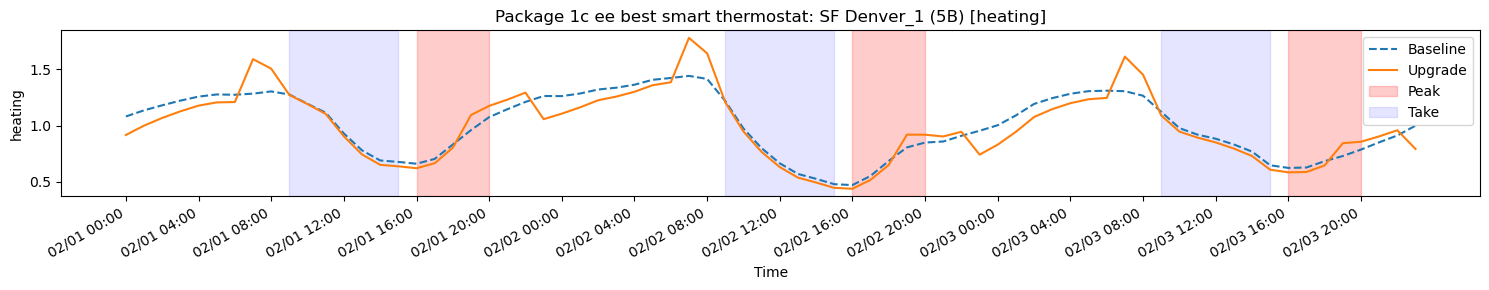

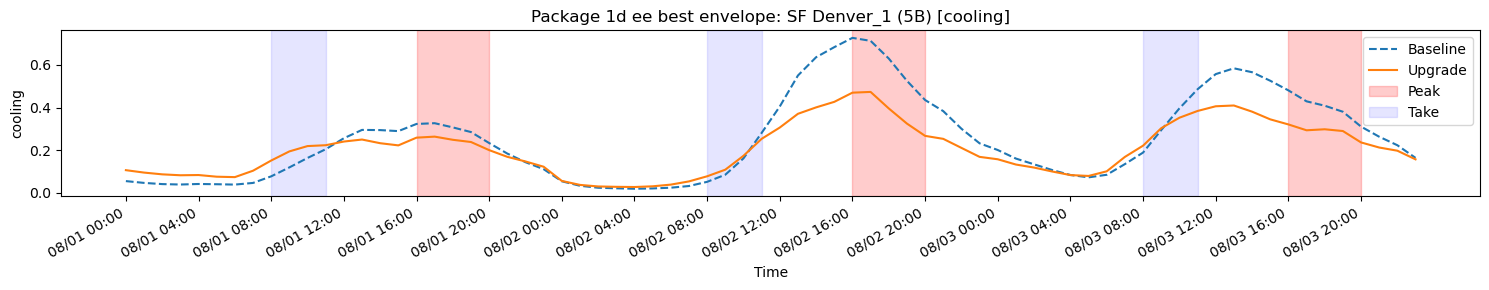

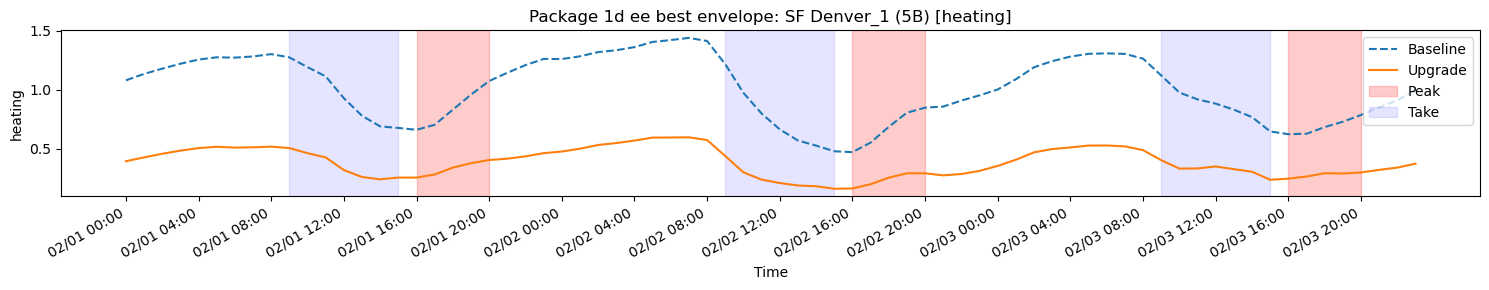

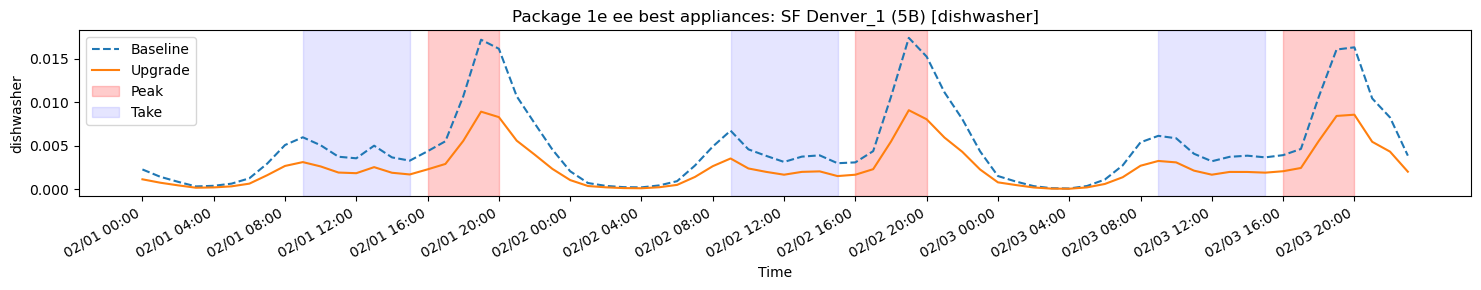

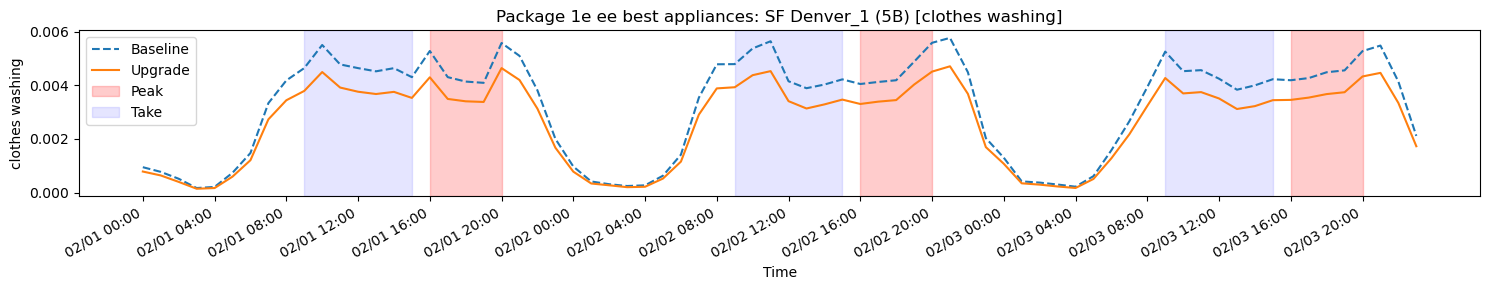

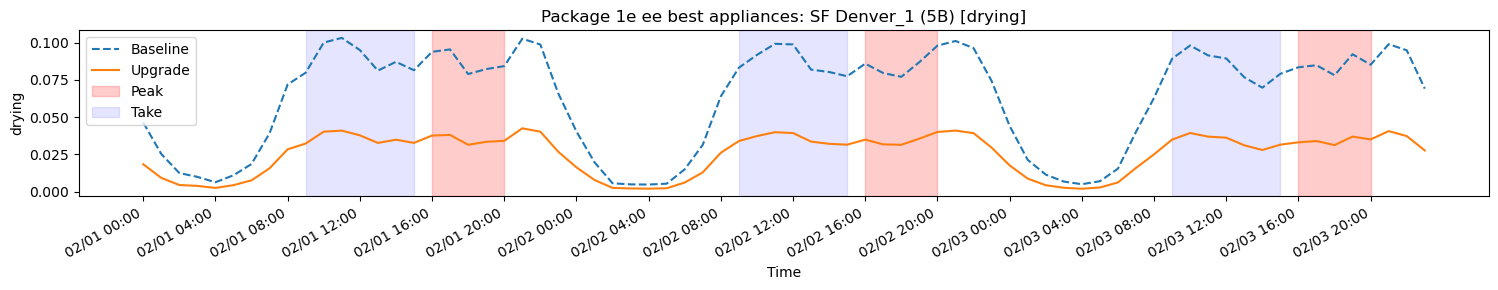

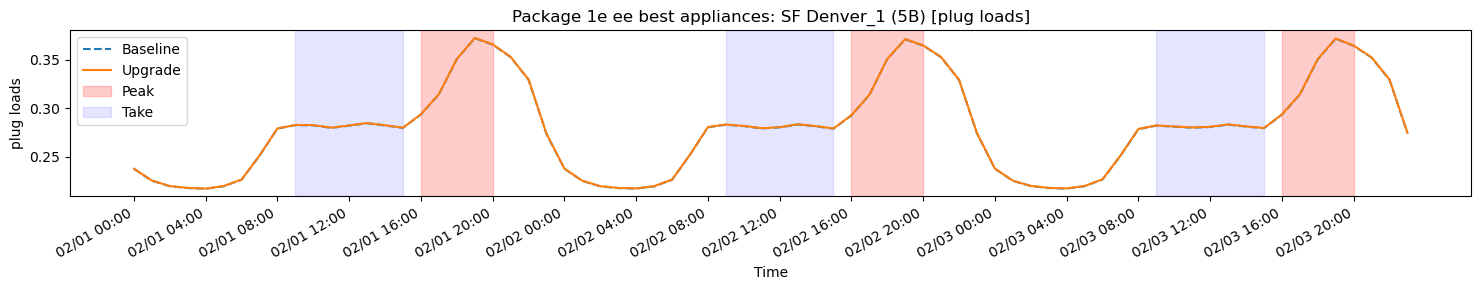

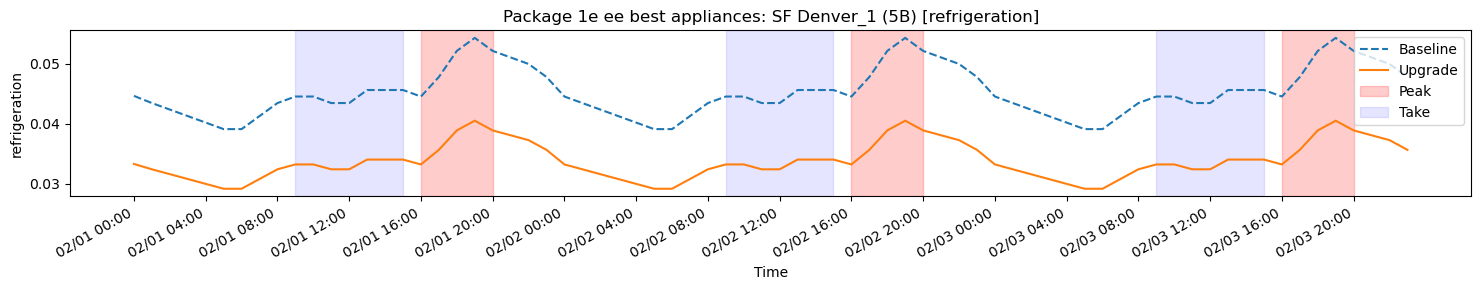

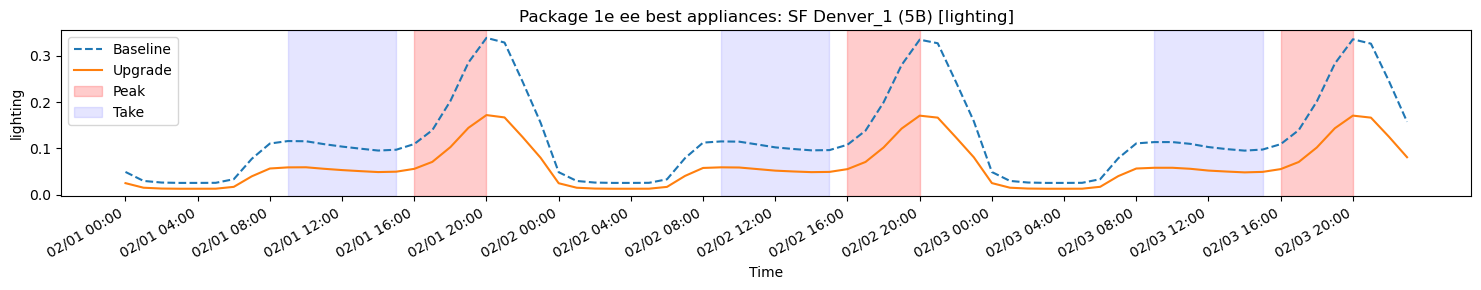

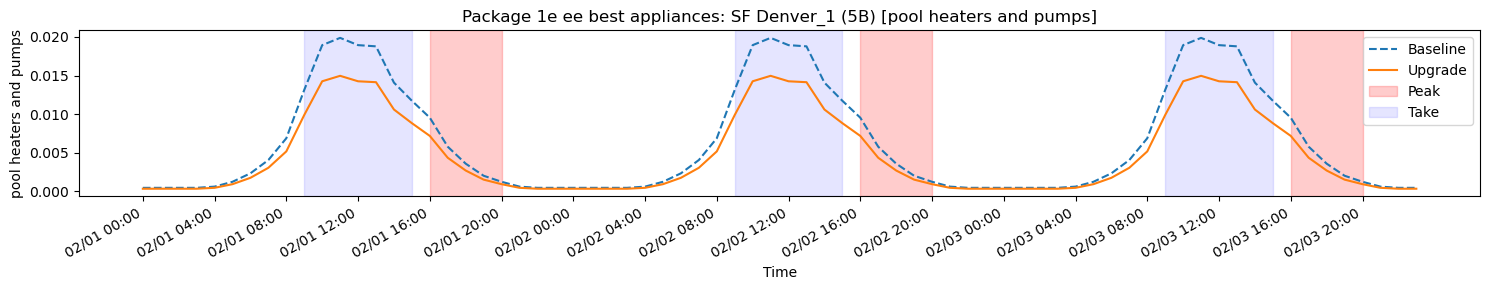

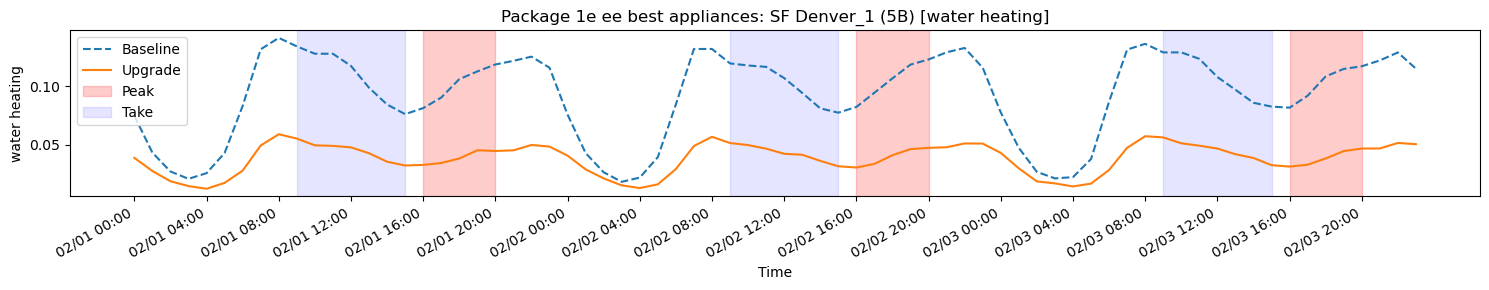

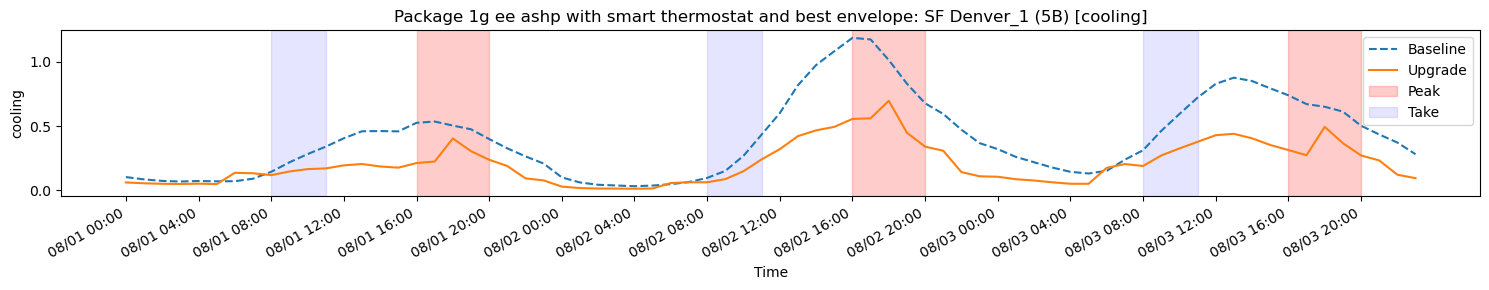

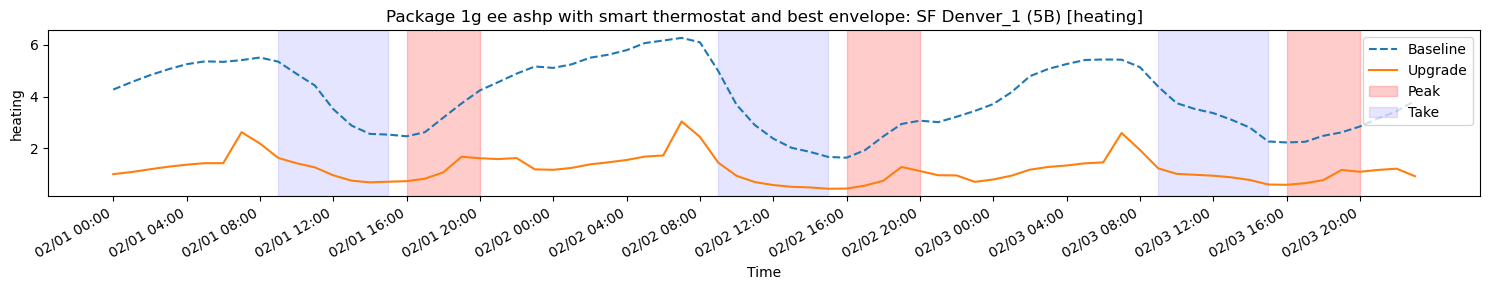

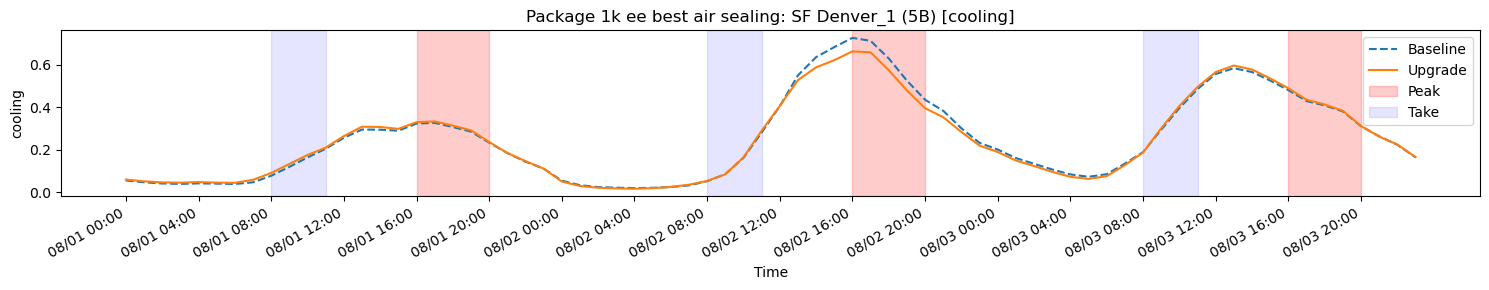

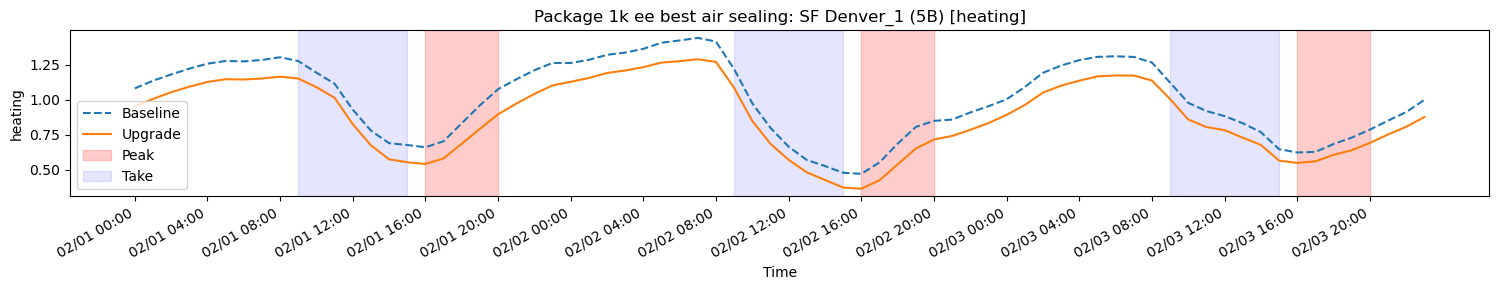

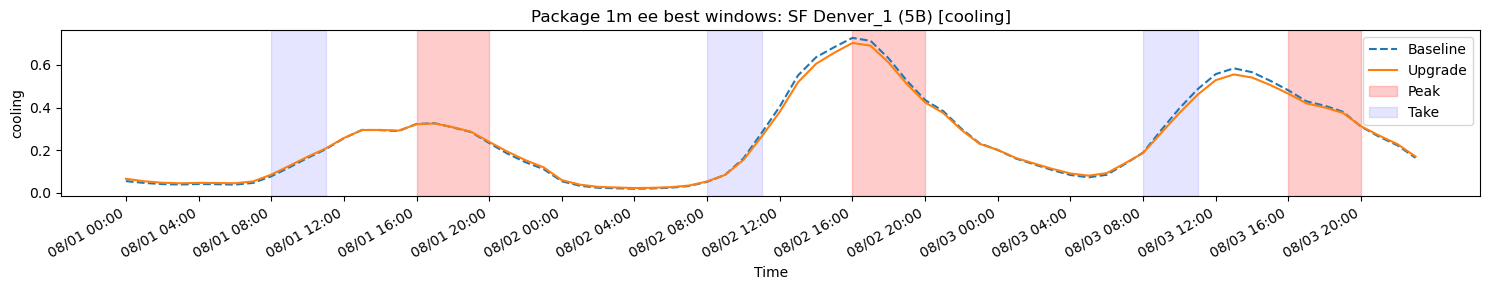

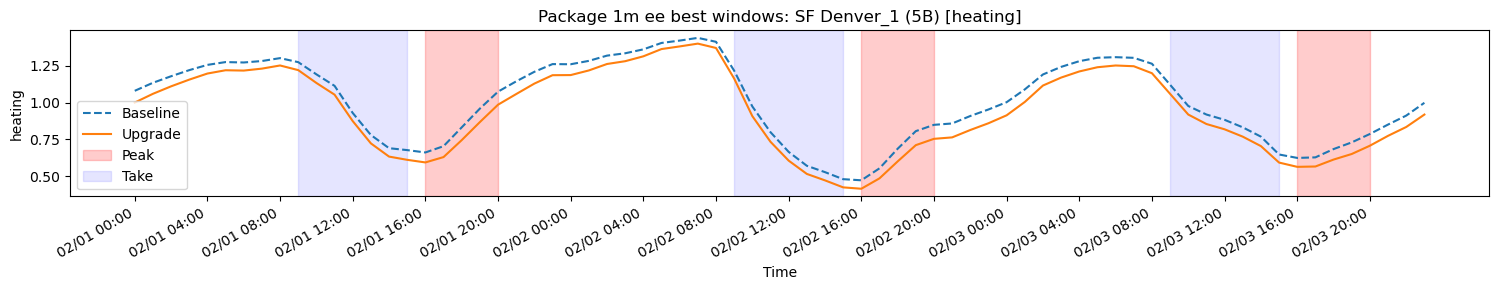

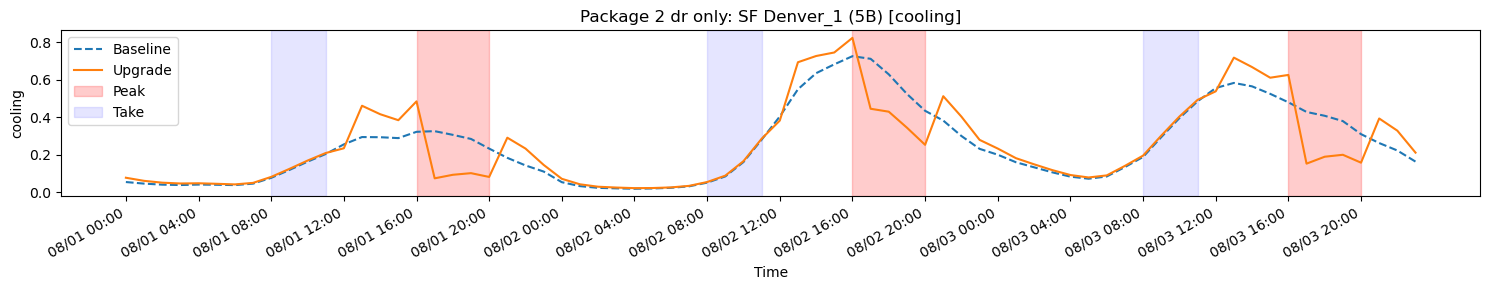

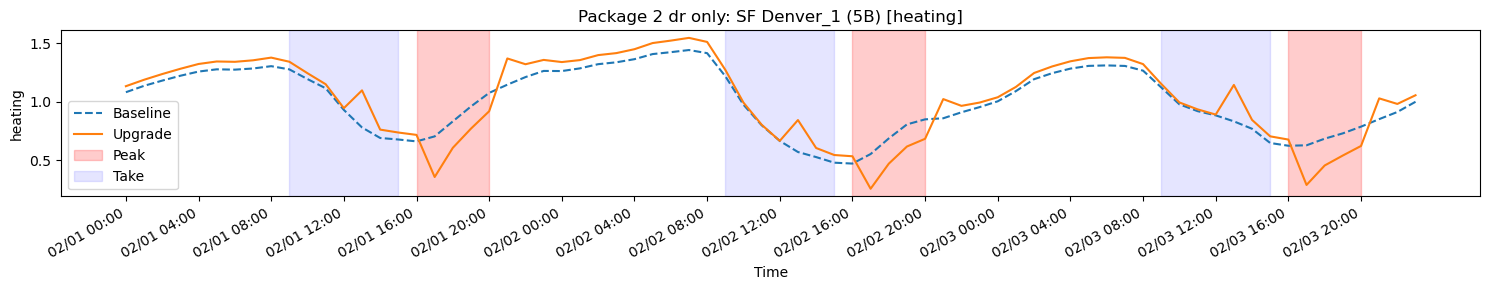

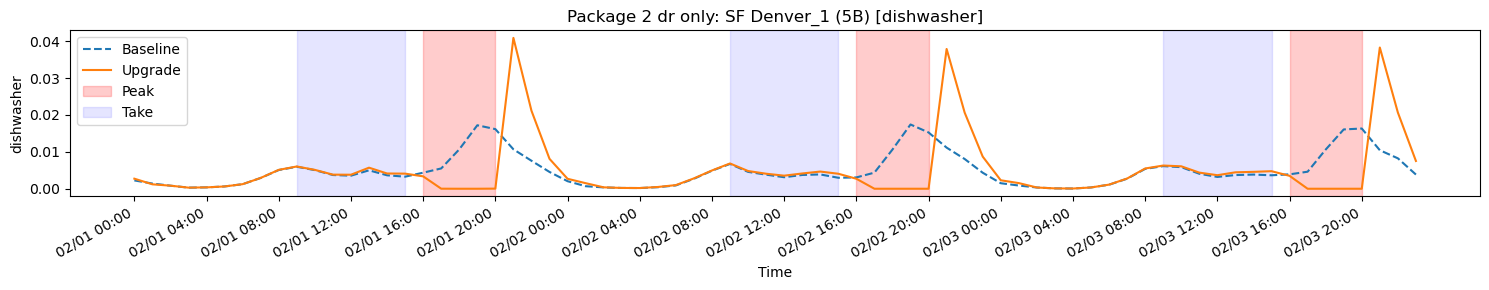

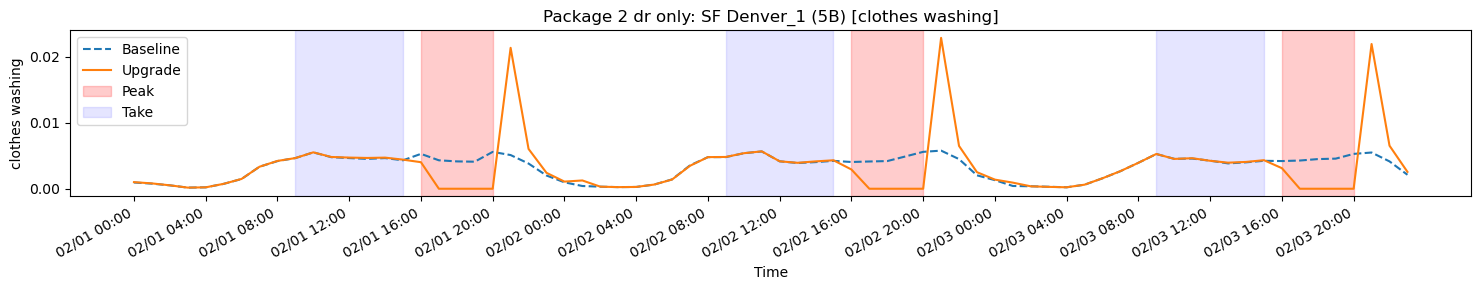

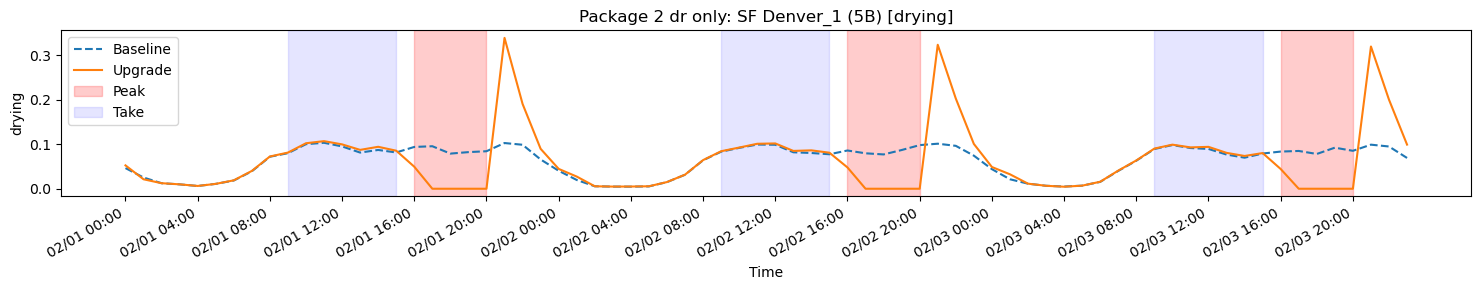

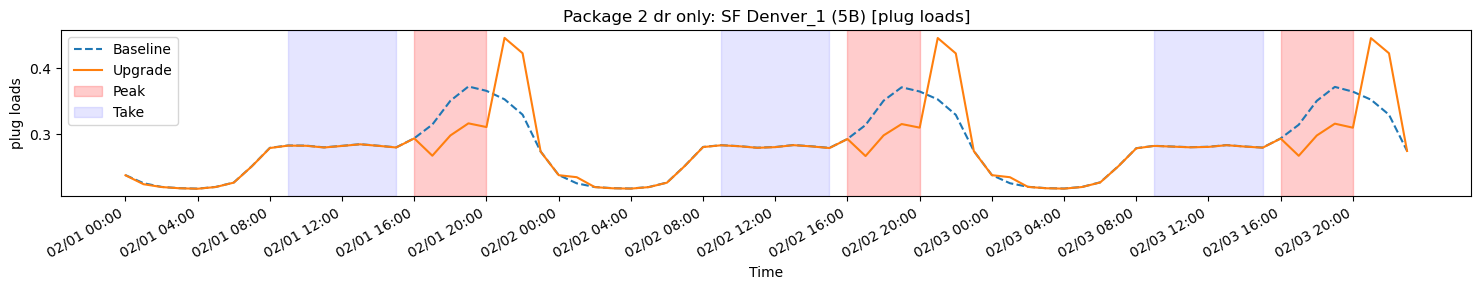

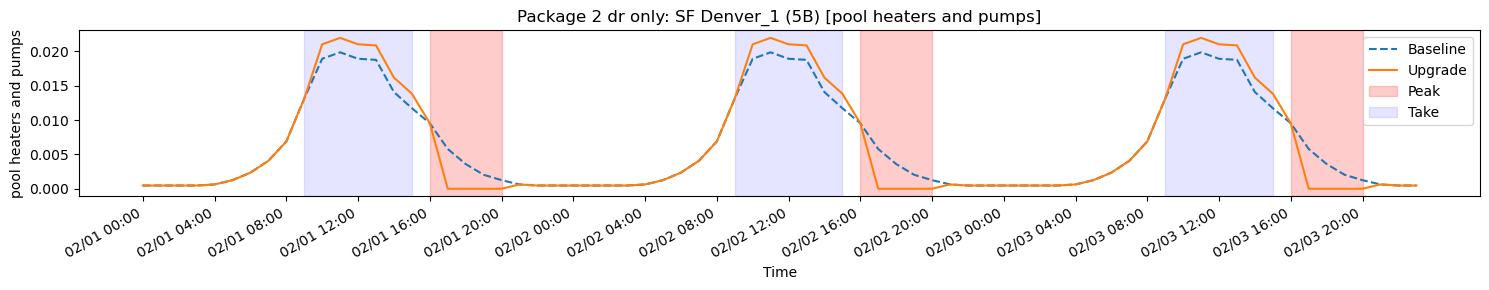

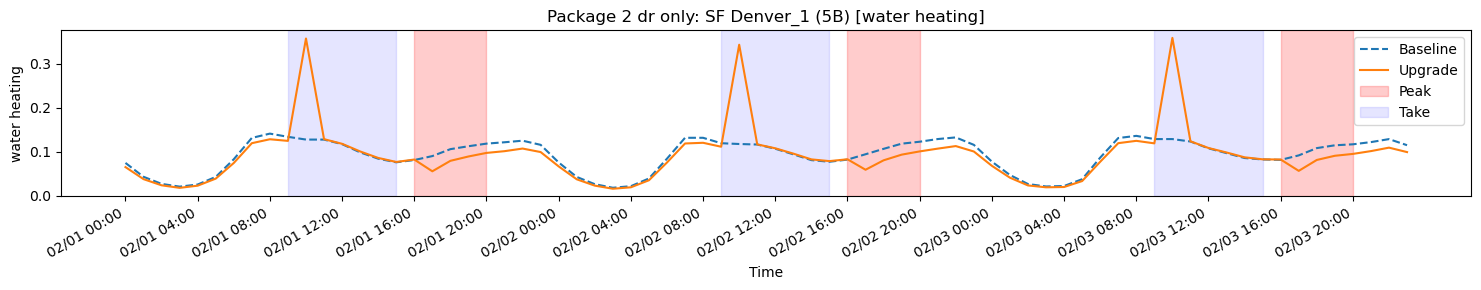

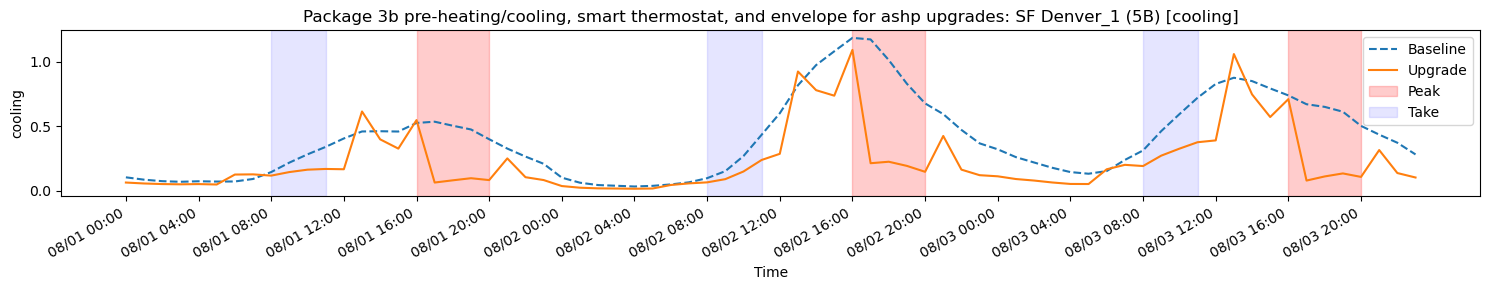

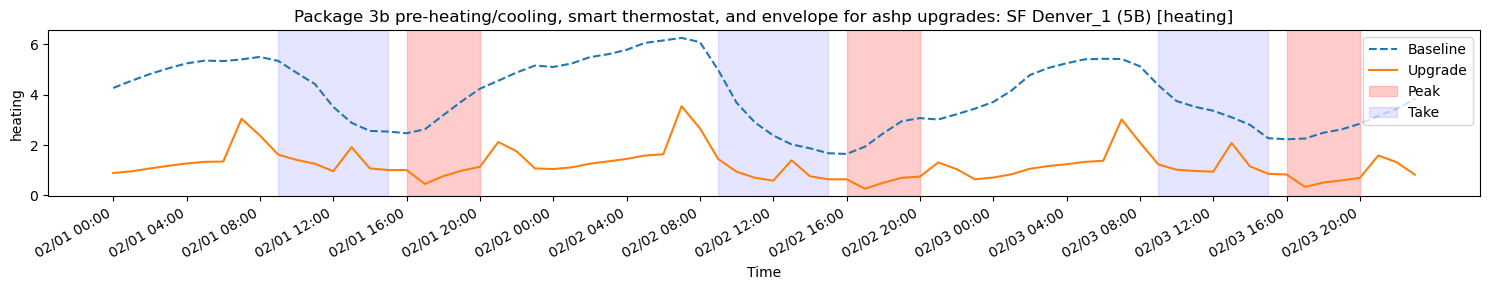

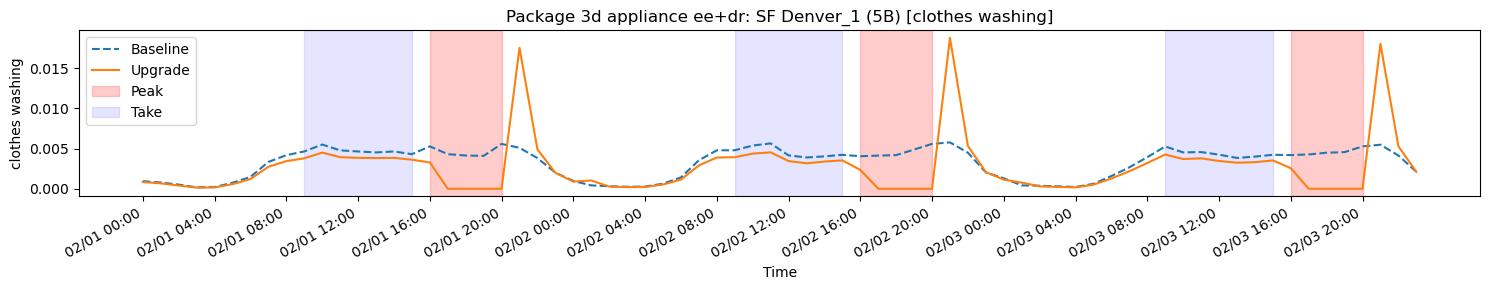

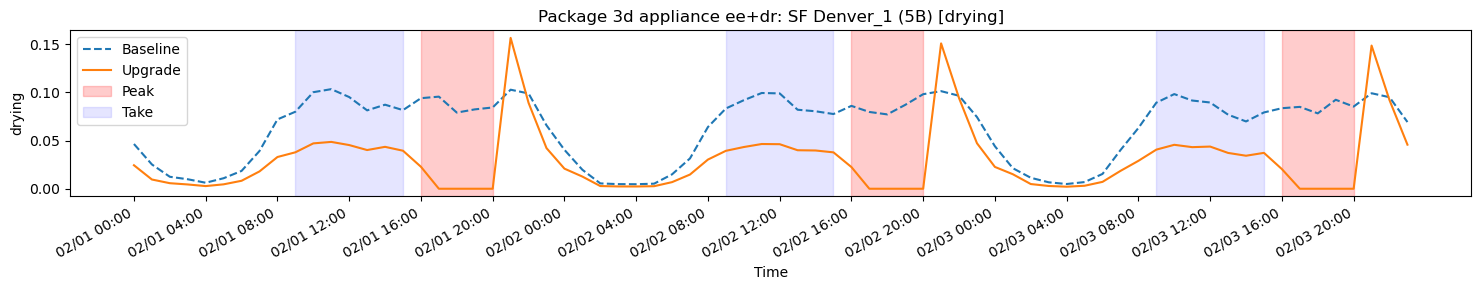

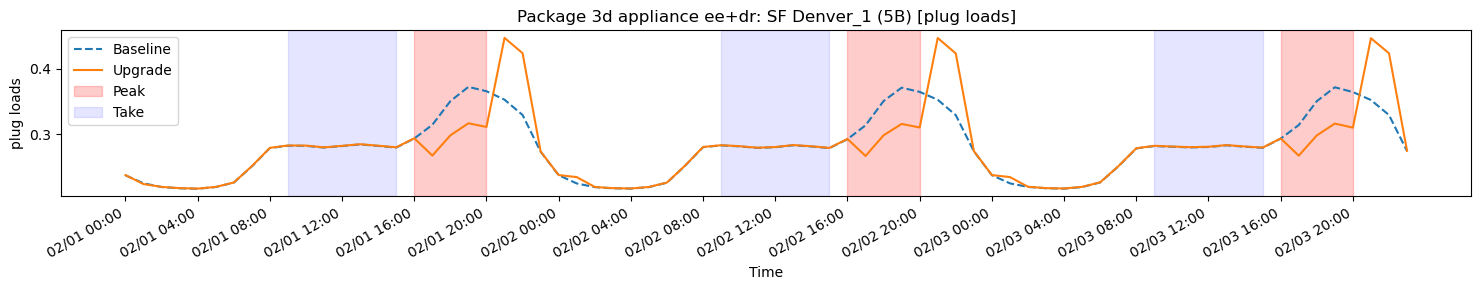

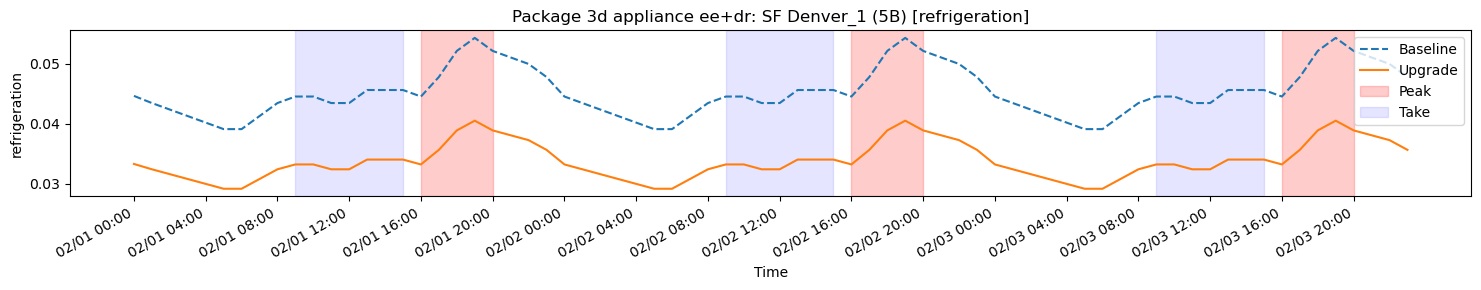

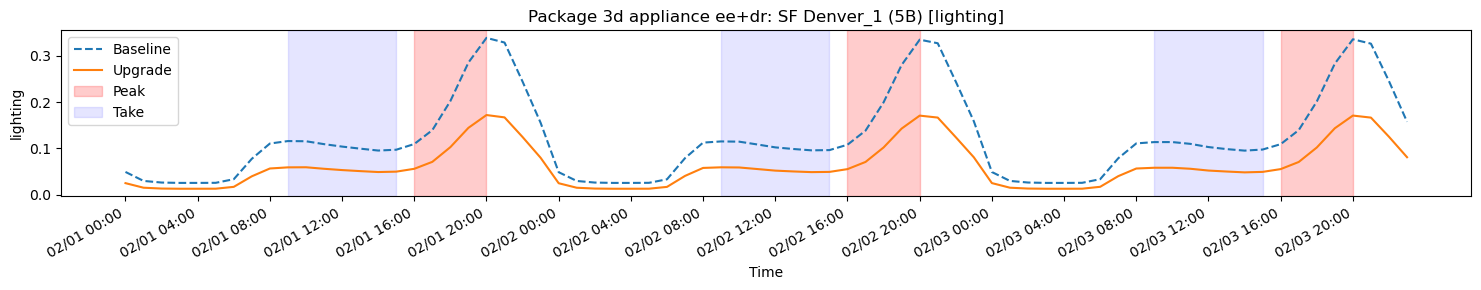

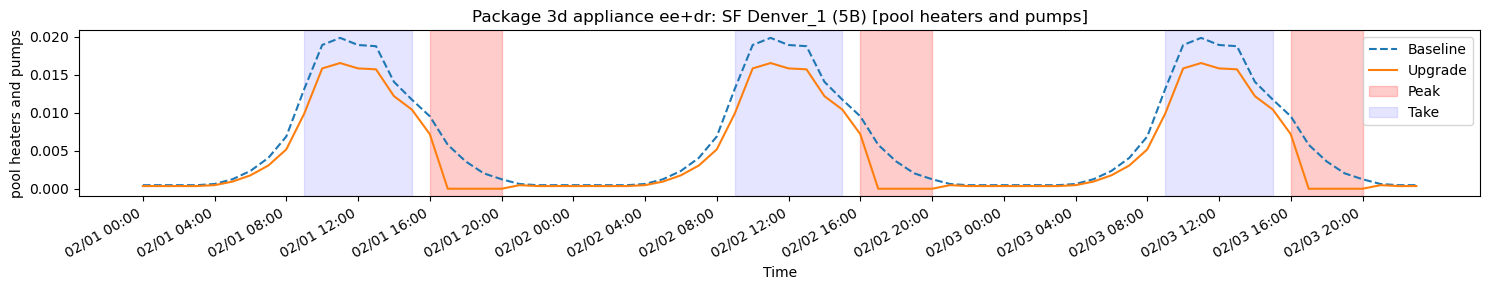

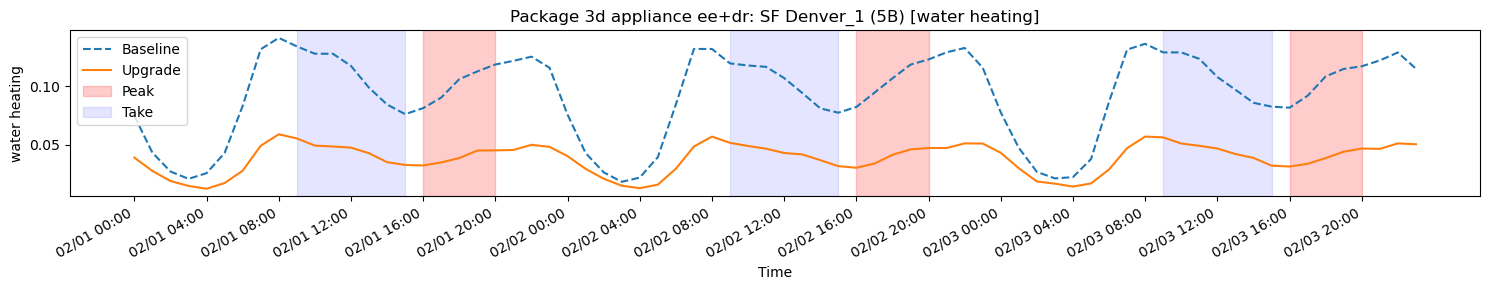

In [280]:
upgrade_keys = [('1b', 'Midland_1', 'cooling'),
                ('1b', 'Midland_1', 'heating'),
                ('1b', 'Denver_1', 'cooling'),
                ('1b', 'Denver_1', 'heating'),
                ('1c', 'Denver_1', 'cooling'),
                ('1c', 'Denver_1', 'heating'),
                ('1d', 'Denver_1', 'cooling'),
                ('1d', 'Denver_1', 'heating'),
                ('1e', 'Denver_1', 'dishwasher'),
                ('1e', 'Denver_1', 'clothes washing'),
                ('1e', 'Denver_1', 'drying'),
                ('1e', 'Denver_1', 'plug loads'),
                ('1e', 'Denver_1', 'refrigeration'),
                ('1e', 'Denver_1', 'lighting'),
                ('1e', 'Denver_1', 'pool heaters and pumps'),
                ('1e', 'Denver_1', 'water heating'),
                ('1g', 'Denver_1', 'cooling'),
                ('1g', 'Denver_1', 'heating'),
                ('1k', 'Denver_1', 'cooling'),
                ('1k', 'Denver_1', 'heating'),
                ('1m', 'Denver_1', 'cooling'),
                ('1m', 'Denver_1', 'heating'),
                ('2', 'Denver_1', 'cooling'),
                ('2', 'Denver_1', 'heating'),
                ('2', 'Denver_1', 'dishwasher'),
                ('2', 'Denver_1', 'clothes washing'),
                ('2', 'Denver_1', 'drying'),
                ('2', 'Denver_1', 'plug loads'),
                ('2', 'Denver_1', 'pool heaters and pumps'),
                ('2', 'Denver_1', 'water heating'),
                ('3b', 'Denver_1', 'cooling'),
                ('3b', 'Denver_1', 'heating'),
                ('3d', 'Denver_1', 'clothes washing'),
                ('3d', 'Denver_1', 'drying'),
                ('3d', 'Denver_1', 'plug loads'),
                ('3d', 'Denver_1', 'refrigeration'),
                ('3d', 'Denver_1', 'lighting'),
                ('3d', 'Denver_1', 'pool heaters and pumps'),
                ('3d', 'Denver_1', 'water heating'),]

btypes = ['SF']
for upgrade_key in upgrade_keys:
    if upgrade_key[-1] == 'cooling':
        start_day = 212
    else:
        start_day = 31
    plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=True)
    

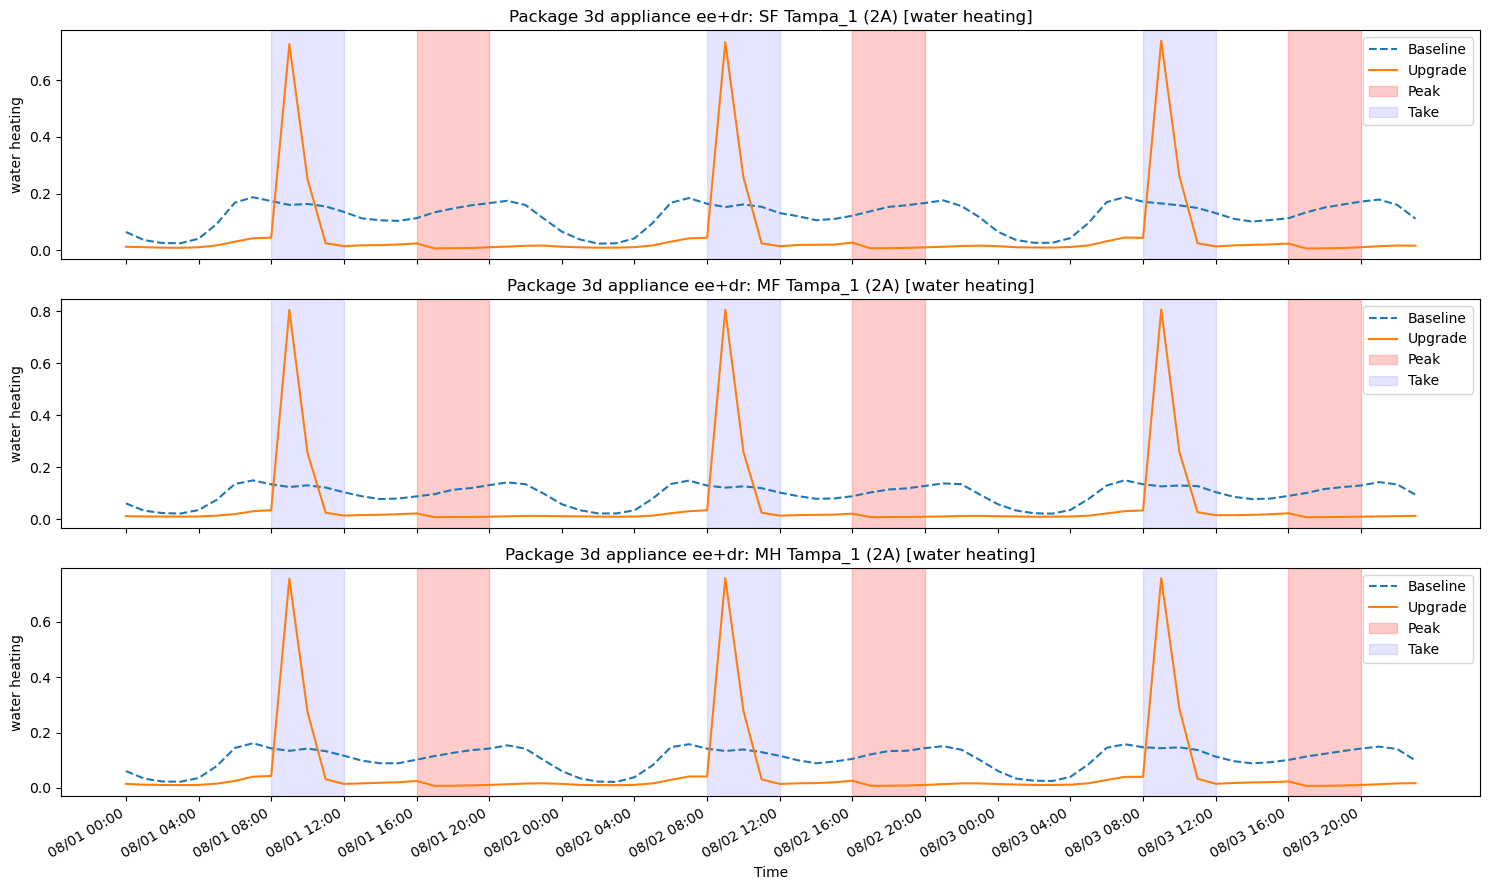

In [12]:
# DENVER - package 3b,summer/winter
btypes = ['SF', 'MF', 'MH']
city = 'Tampa_1'
enduse= 'water heating'

start_day = 212
upgrade_key = ('3d', city, enduse)
plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=False)

# start_day = 31
upgrade_key = ('1e', city, enduse)
# plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=False)

upgrade_key = ('2', city, enduse)
# plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=False)


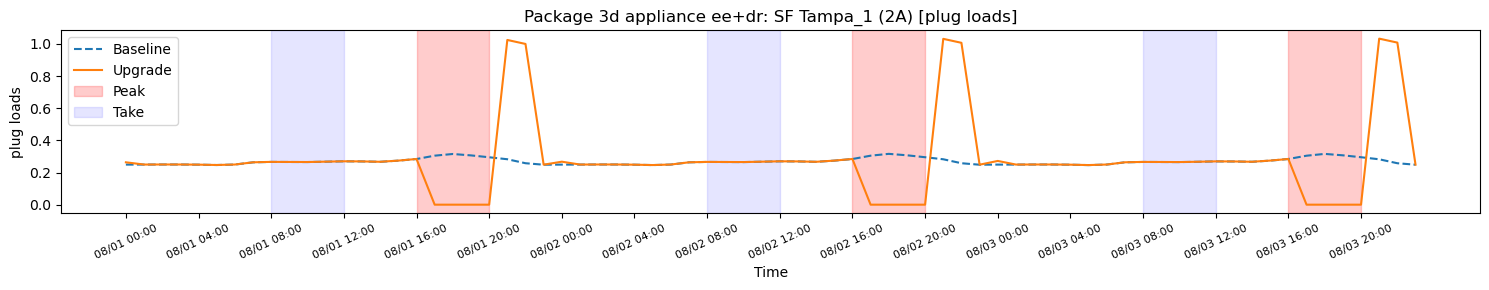

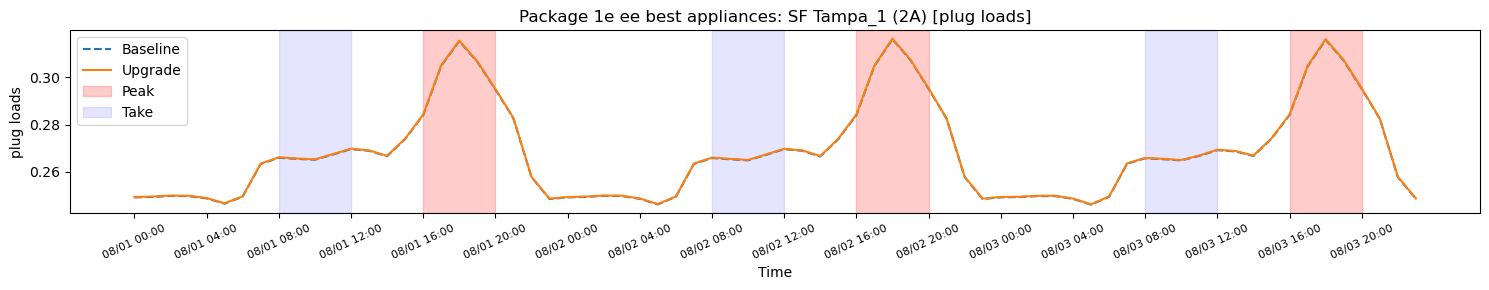

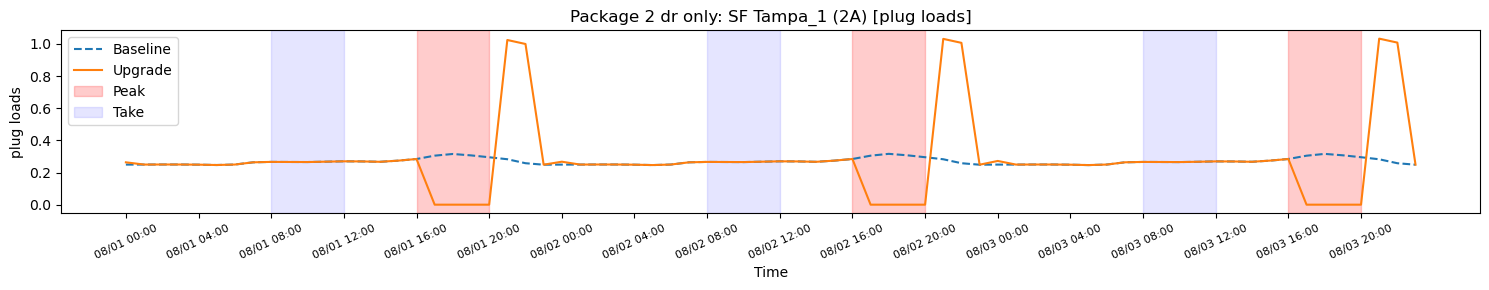

In [274]:
# DENVER - package 3b,summer/winter
btypes = ['SF']
city = 'Tampa_1'
enduse= 'plug loads'

start_day = 212
upgrade_key = ('3d', city, enduse)
plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=False)

# start_day = 31
upgrade_key = ('1e', city, enduse)
plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=False)

upgrade_key = ('2', city, enduse)
plot_single_upgrade(*upgrade_key, start_day, period=3*24, btypes=btypes, showfig=True, savefig=False)
